# Spelling Errors at the Scripps National Spelling Bee

## Objective

To predict whether a selected word will result in a spelling error at the Scripps National Spelling Bee based on 1996-2017 spelling bee data

## Import Libraries and Read In Data

In [3]:
#General Imports
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chi2_contingency

In [4]:
#Read In Data
data = pd.read_csv('Data2_AR.csv')
data.drop([col for col in data.columns if "Unnamed" in col], axis=1, inplace=True)

## General Overview of Data

In [22]:
data.shape

(14672, 11)

In [4]:
data.dtypes

Word                     object
Year                      int64
Round                     int64
Part_of_Speech           object
Language                 object
Times_Used                int64
Years_Since_Last_Used     int64
Num_Syllables             int64
Word_Length               int64
Reduplication             int64
Error                     int64
dtype: object

## Data Sources

I collected data from the following sources:

**Primary Data Set:** https://github.com/octonion/spelling

**Data for Missing Years:** 
- https://secure.spellingbee.com/public/results/2012/round_results
- https://secure.spellingbee.com/public/results/2013/round_results
- https://secure.spellingbee.com/public/results/2014/round_results

**Etymological, Part of Speech, and Syllabification Data:** https://www.merriam-webster.com/

**Additional Etymological Data:** 

- http://www.etymonline.com/
- http://www.wiktionary.com

## Creation of Dummy Variables

In [7]:
#Create Part of Speech Dummy Variables
pos_dum = pd.get_dummies(data.Part_of_Speech, prefix='pos')

pos_dum.drop('pos_noun', axis=1, inplace=True)

data = pd.concat([data, pos_dum], axis=1)

In [8]:
#Create Language Dummy Variables
lang_dum = pd.get_dummies(data.Language, prefix='lang')

lang_dum.drop('lang_Latin or Greek', axis=1, inplace=True)

data = pd.concat([data, lang_dum], axis=1)

## Feature Selection

In [9]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFdr
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [10]:
feature_cols = ['Round', 'Times_Used', 'Years_Since_Last_Used', 'Reduplication', 'Num_Syllables', 'Word_Length', 'pos_adjective', 'pos_verb', 'pos_other', 'lang_Germanic', 'lang_Western European', 'lang_Other']
X = data[feature_cols]
y = data.Error

### Univariate Feature Selection

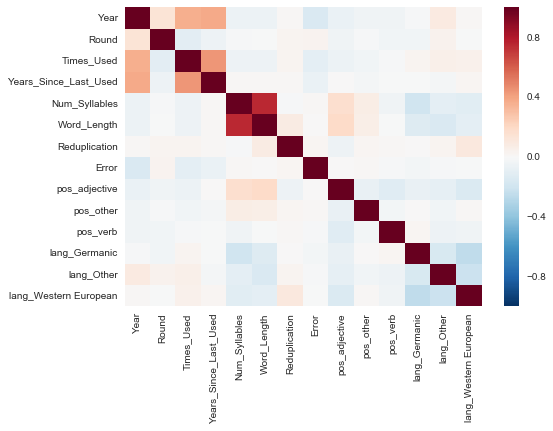

In [12]:
sns.heatmap(data.corr())

**What is univariate feature selection?**


Univariate feature selection methods, such as correlation matrices, work with each feature individually, often exploring interactions between individual features and the target variable, rather than examining the data set as a whole. Types of univariate feature selection that I used include correlation matrices, lasso, K best selection, and chi2 selection. Each of these methods found the same features to be the most important, as detailed below.

**Important Features:**
- Round
- Times Used
- Years Since Last Used
- Reduplication
- Language of Origin

### Feature Importance Using Random Forest

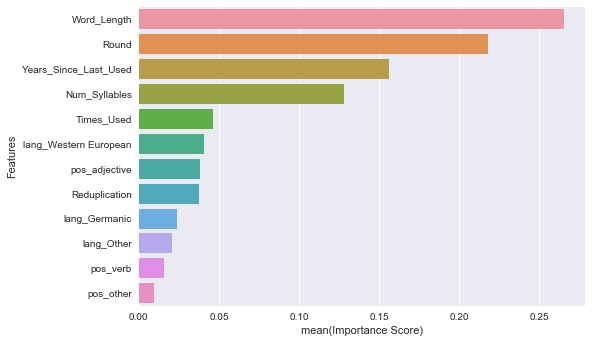

In [209]:
rf = RandomForestClassifier()
rf.fit(X,y)
feature_importances = rf.feature_importances_
features_df = pd.DataFrame({'Features': feature_cols, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

**How is feature importance different from univariate feature selection?**

Unlike univariate feature selection, feature importance in random forests looks at several features and examines how they interact with each other as well as with the target variable. As noted below, the features identified by random forest as being most important were similar but not identical to those selected via univariate feature selection.

**Important Features:**
- Round
- Times Used
- Years Since Last Used
- Word Length
- Number of Syllables

## Error Rate

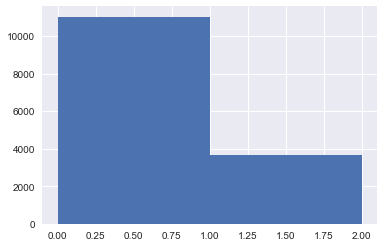

In [75]:
data.Error.hist(bins=[0,1,2])

In [18]:
data.Error.value_counts(normalize=True)

0    0.751636
1    0.248364
Name: Error, dtype: float64

## Classification Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### K Nearest Neighbors (KNN)

In [641]:
feature_cols = ['Round', 'Years_Since_Last_Used', 'Times_Used', 'Reduplication', 'lang_Germanic']
X = data[feature_cols]
y = data.Error
knn = KNeighborsClassifier(n_neighbors = 251)
scores = cross_val_score(knn, X, y, cv=10)
scores.mean()

0.75163585283230527

In [673]:
feature_cols = ['Round', 'Years_Since_Last_Used', 'Times_Used', 'Word_Length']
X = data[feature_cols]
y = data.Error
knn = KNeighborsClassifier(n_neighbors = 251)
scores = cross_val_score(knn, X, y, cv=10)
scores.mean()

0.75163585283230527

**Distinctive Aspects of Algorithm:**

- Based on feature similarity
- Sensitive to scale of data
- Sensitive to irrelevant features

**Application:**

For every option for each feature, more words are spelled correctly than are spelled incorrectly. Often, this difference is significant (>75% of words are spelled correctly). As such, KNN is likely to predict that a word will be spelled correctly regardless of which features are selected. The prediction accuracy with KNN matches the accuracy when all words are predicted to be spelled correctly.

### Logistic Regression

In [643]:
feature_cols = ['Round', 'Years_Since_Last_Used', 'Times_Used', 'Reduplication', 'lang_Germanic']
X = data[feature_cols]
y = data.Error
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=10)
scores.mean()

0.75163585283230527

In [772]:
feature_cols = ['Round', 'Years_Since_Last_Used', 'Times_Used', 'Word_Length']
X = data[feature_cols]
y = data.Error
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=10)
scores.mean()

0.75163585283230527

**Distinctive Aspects of Algorithm:**

- Requires linearly divisible features
- Can't automatically learn feature interactions

**Application:**

Because distinct options within features resemble each other, features are not linearly divisible. The vast majority of words within each option are spelled correctly. The model is unable to make distinctions and therefore predicts each word as spelled correctly. The accuracy of the model matches the default accuracy when all words are predicted to be spelled correctly.

### Decision Trees

In [677]:
feature_cols = ['Round', 'Times_Used', 'Years_Since_Last_Used', 'Reduplication', 'lang_Western European']
X = data[feature_cols]
y = data.Error
dt = DecisionTreeClassifier(max_depth=6)
scores = cross_val_score(dt, X, y, cv=10)
scores.mean()

0.75184016600715398

In [770]:
feature_cols = ['Word_Length', 'Years_Since_Last_Used', 'Round', 'Times_Used']
X = data[feature_cols]
y = data.Error
dt = DecisionTreeClassifier(max_depth=4)
scores = cross_val_score(dt, X, y, cv=10)
scores.mean()

0.75170406565631631

### Random Forest

In [752]:
feature_cols = ['Round', 'Times_Used', 'Years_Since_Last_Used', 'Reduplication', 'lang_Western European']
X = data[feature_cols]
y = data.Error
rf = RandomForestClassifier(max_depth=7, min_samples_leaf=40, oob_score=True)
scores = cross_val_score(rf, X, y, cv=10)
scores.mean()

0.75204466504800815

In [759]:
feature_cols = ['Round', 'Times_Used', 'Years_Since_Last_Used', 'Word_Length']
X = data[feature_cols]
y = data.Error
rf = RandomForestClassifier(max_depth=7, min_samples_leaf=40, oob_score=True)
scores = cross_val_score(rf, X, y, cv=10)
scores.mean()

0.75184035180981046

**Distinctive Aspects of Algorithm:**

- Non-parametric
- Non-linear

**Application:**

Decision trees are ideal for working with otherwise seemingly unpredictable data, such as the Scripps Spelling Bee data. As a non-parametric algorithm, decision trees do not require the underlying data to be distributed or structured in any particular way. Unlike logistic regression, as a non-linear algorithm, decision trees do not rely on linearly divisible features. Additionally, decision trees are less sensitive than KNN. 

Unfortunately, decision trees are prone to over-fitting. This tendency is mitigated by limiting the depth of the trees and setting a value higher than 1 for the number of samples required to form a leaf. 

Interestingly, both decision trees and random forests made more accurate predictions with the features selected through univariate feature selection than through features selected by feature importance in random forests or by examining the variance threshold. This may be explained by the exploration of interactions between features and error rate done during univarite feature selection.

## Summary of Findings

- Data is largely unpredictable. To the extent that it is predictable:
    - Bee-Specific Features are of primary importance:
        - Round
        - Times Used
        - Years Since Last Used
    - Word-Specific Features are of secondary importance:
        - Word Length
        - Number of Syllables
        - Reduplication
        - Language of Origin
        - Part of Speech

## Ideas for Future Exploration

- **Partial Reduplication:** Repetition of letters separated by distinct characters


- **Speller-Specific Features:**
    - Age
    - Gender
    - State
    - Grade
    - School Type